Device: cpu
Sequence shapes: Xtr, ytr, Xte, yte = (838, 30, 1) (838, 1) (343, 30, 1) (343, 1)
[Adam] Epoch 1/80 train_loss=0.149797 val_loss=0.257683 lr=1.00e-03
[Adam] Epoch 5/80 train_loss=0.025612 val_loss=0.192575 lr=1.00e-03
[Adam] Epoch 10/80 train_loss=0.013482 val_loss=0.131680 lr=1.00e-03
[Adam] Epoch 15/80 train_loss=0.010681 val_loss=0.100004 lr=1.00e-03
[Adam] Epoch 20/80 train_loss=0.009178 val_loss=0.091109 lr=1.00e-03
[Adam] Epoch 25/80 train_loss=0.008248 val_loss=0.072751 lr=1.00e-03
[Adam] Epoch 30/80 train_loss=0.007530 val_loss=0.077392 lr=5.00e-04
[Adam] Epoch 35/80 train_loss=0.006729 val_loss=0.038584 lr=5.00e-04
[Adam] Epoch 40/80 train_loss=0.006485 val_loss=0.044078 lr=5.00e-04
[Adam] Epoch 45/80 train_loss=0.006660 val_loss=0.030345 lr=2.50e-04
[Adam] Epoch 50/80 train_loss=0.006341 val_loss=0.029529 lr=2.50e-04
[Adam] Epoch 55/80 train_loss=0.005920 val_loss=0.027304 lr=1.25e-04
[Adam] Epoch 60/80 train_loss=0.006074 val_loss=0.028126 lr=1.25e-04
[Adam] Epoc

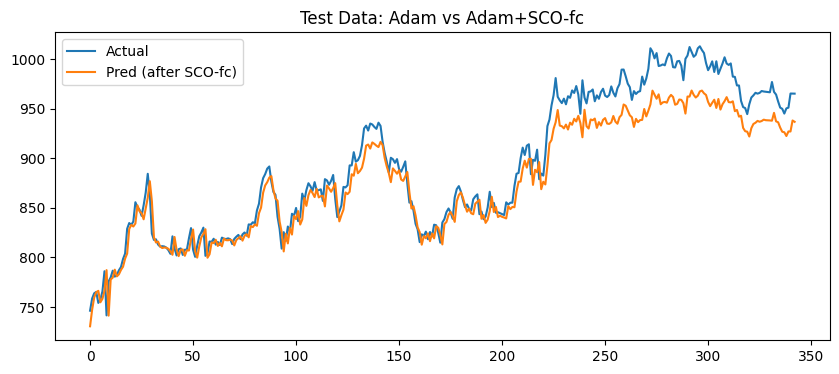

In [ ]:
# lstm_keep_base_model_multifeature_embeddings.py
import os, math, warnings, time, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ---------------- reproducibility (unchanged) ----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ---------------- device ----------------
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ---------------- user config (kept like your base) ----------------
data_dir = "../Data"
ticker = 'HDFCBANK.NS'
csv_path = os.path.join(data_dir, f"{ticker}_features.csv")
emb_dir = os.path.join(data_dir, "embeddings")
os.makedirs(emb_dir, exist_ok=True)

lookback = 30             # keep your original lookback
BATCH_SIZE = 16           # keep original
pretrain_epochs = 80
patience = 10
clip_value = 1.0
LR = 1e-3

# ---------------- indicator functions (copied from GRU) ----------------
def ema(series: pd.Series, span: int) -> pd.Series:
    k = 2 / (span + 1)
    return series.ewm(alpha=k, adjust=False).mean()

def wilder_ema(series: pd.Series, period: int) -> pd.Series:
    return series.ewm(alpha=1/period, adjust=False).mean()

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_up = wilder_ema(up, period)
    avg_down = wilder_ema(down, period)
    rs = avg_up / (avg_down.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

def macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def atr_wilder(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return wilder_ema(tr, period)

def stochastic_oscillator(df: pd.DataFrame, k_period=14, d_period=3):
    low_min = df['Low'].rolling(k_period).min()
    high_max = df['High'].rolling(k_period).max()
    k = 100 * (df['Close'] - low_min) / (high_max - low_min)
    d = k.rolling(d_period).mean()
    return k.fillna(50), d.fillna(50)

def obv(df: pd.DataFrame):
    obv_series = np.zeros(len(df))
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            obv_series[i] = obv_series[i-1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            obv_series[i] = obv_series[i-1] - df['Volume'].iloc[i]
        else:
            obv_series[i] = obv_series[i-1]
    return pd.Series(obv_series, index=df.index)

# ---------------- load CSV ----------------
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found. Put CSV at this path.")

raw = pd.read_csv(csv_path)
# normalize column capitalization like GRU
raw.rename(columns={c: c.title() for c in raw.columns}, inplace=True)

# check essential columns
for col in ['Open','High','Low','Close','Volume']:
    if col not in raw.columns:
        raise KeyError(f"Missing required column: {col}")

# ---------------- build features (same indicators as GRU) ----------------
features = raw[[
    'Open',
    # 'High',
    # 'Low',
    'Volume',
    'Close',
]].dropna().reset_index(drop=True)
# features['LogRet'] = np.log(features['Close']).diff().fillna(0.0)
# features['RSI14'] = rsi_wilder(features['Close'], 14)
# m, s, h = macd(features['Close'])
# features['MACD'] = m
# features['MACD_SIGNAL'] = s
# features['MACD_HIST'] = h
# features['ATR14'] = atr_wilder(features['High'], features['Low'], features['Close'], 14)
# features['EMA5'] = ema(features['Close'], 5)
# features['EMA10'] = ema(features['Close'], 10)
# features['STOCH_K'], features['STOCH_D'] = stochastic_oscillator(features)
# features['OBV'] = obv(features)
features = features.dropna().reset_index(drop=True)

# ---------------- target: single-step (next day Close) — keeps your base objective ----------------
# y at index t will be Close at t+1
y_full = features['Close'].shift(-1).dropna().reset_index(drop=True)
# trim features to match y length
features = features.iloc[:-1, :].reset_index(drop=True)

# ---------------- scaling (keep your original ranges: (-1,1)) ----------------
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_all = features.values         # shape (N, n_features)
y_all = y_full.values.reshape(-1, 1)  # shape (N,1)

split_index = int(len(X_all) * 0.70)   # keep your 70/30 split
X_train_s = scaler_X.fit_transform(X_all[:split_index])
X_test_s  = scaler_X.transform(X_all[split_index:])

y_train_s = scaler_y.fit_transform(y_all[:split_index])
y_test_s  = scaler_y.transform(y_all[split_index:])

# ---------------- sequence creation (your original lookback logic) ----------------
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])   # single-step target aligned w/ last timestep
    return np.array(Xs), np.array(ys)

Xtr, ytr = make_sequences(X_train_s, y_train_s, lookback)
Xte, yte = make_sequences(X_test_s, y_test_s, lookback)

print("Sequence shapes: Xtr, ytr, Xte, yte =", Xtr.shape, ytr.shape, Xte.shape, yte.shape)

# convert to torch tensors with correct feature dim
X_train = torch.tensor(Xtr).float().to(device)   # shape (N_train, lookback, n_features)
X_test  = torch.tensor(Xte).float().to(device)
y_train = torch.tensor(ytr).float().to(device)   # shape (N_train, 1)
y_test  = torch.tensor(yte).float().to(device)

# ---------------- dataset / dataloader (same as your base) ----------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# ---------------- model: keep your base LSTM exactly but accept multivariate input ----------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        # same as your model but input_size is now n_features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, n_features)
        batch_size = x.size(0)
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        last = out[:, -1, :]           # last hidden vector (embedding-like)
        out = self.fc(last)            # single-step prediction
        return out

    def get_embedding(self, x):
        # return the last hidden vector (embedding) for input x
        with torch.no_grad():
            batch_size = x.size(0)
            h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            last = out[:, -1, :]
        return last.cpu().numpy()   # return as numpy

# instantiate model with input_size = n_features (so behavior otherwise unchanged)
n_features = Xtr.shape[-1]
model = LSTMModel(input_size=n_features, hidden_size=64, num_layers=2, dropout=0.2).to(device)
loss_function = nn.MSELoss()

# ---------------- helper functions (unchanged) ----------------
def evaluate_loss_on_loader(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            b = xb.size(0)
            total_loss += loss.item() * b
            total_samples += b
    return total_loss / max(1, total_samples)

def get_flat_params_from_module(module):
    return torch.cat([p.data.view(-1) for p in module.parameters()]).detach()

def set_flat_params_to_module(module, flat_params):
    idx = 0
    for p in module.parameters():
        n = p.numel()
        p.data.copy_(flat_params[idx: idx + n].view_as(p).to(p.device))
        idx += n

# ---------------- Adam pretraining with early stopping & scheduler (kept same) ----------------
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val = float('inf')
best_state = None
no_improve = 0

for epoch in range(pretrain_epochs):
    model.train()
    running = 0.0
    count = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_function(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running += loss.item() * xb.size(0)
        count += xb.size(0)
    train_loss = running / max(1, count)
    val_loss = evaluate_loss_on_loader(model, test_loader, loss_function, device)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"[Adam] Epoch {epoch+1}/{pretrain_epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f} lr={current_lr:.2e}")

    # early stopping
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
        break

# restore best state if found
if best_state is not None:
    model.load_state_dict(best_state)

# ---------------- Metrics after Adam (unchanged) ----------------
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(device)).cpu().numpy()
    test_pred = model(X_test.to(device)).cpu().numpy()

train_pred_inv = scaler_y.inverse_transform(train_pred)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_train_inv = scaler_y.inverse_transform(y_train.cpu().numpy())
y_test_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

mae_adam = mean_absolute_error(y_test_inv.flatten(), test_pred_inv.flatten())
rmse_adam = math.sqrt(mean_squared_error(y_test_inv.flatten(), test_pred_inv.flatten()))
mape_adam = mean_absolute_percentage_error(y_test_inv.flatten(), test_pred_inv.flatten()) * 100
acc_adam = 100 - mape_adam

print("\nAfter Adam pretraining (metrics):")
print(f"MAE: {mae_adam:.4f}")
print(f"RMSE: {rmse_adam:.4f}")
print(f"MAPE: {mape_adam:.3f}%")
print(f"Calculated Accuracy: {acc_adam:.3f}%")

# ---------------- SandCat-style fine-tune on final fc layer only (unchanged) ----------------
class SandCatFC:
    def __init__(self, n_agents=20, sigma=0.02, device='cpu', verbose=True):
        self.n_agents = int(n_agents)
        self.sigma = float(sigma)
        self.device = device
        self.verbose = verbose

    def optimize(self, model, train_loader, val_loader, loss_fn, epochs=10):
        module = model.fc
        best_pos = get_flat_params_from_module(module).to(self.device).clone()
        dim = best_pos.numel()
        base_scale = (best_pos.abs() + 1.0).to(self.device)
        pop = best_pos.unsqueeze(0).repeat(self.n_agents, 1) + \
              (self.sigma * torch.randn(self.n_agents, dim, device=self.device) * base_scale.unsqueeze(0))
        best_score = float('inf')
        for it in range(epochs):
            if self.verbose:
                print(f"[SCO-FC] iter {it+1}/{epochs} evaluating {self.n_agents} agents...")
            scores = []
            for i in range(self.n_agents):
                cand = pop[i]
                set_flat_params_to_module(module, cand)
                train_loss = evaluate_loss_on_loader(model, train_loader, loss_fn, self.device)
                scores.append(train_loss)
            scores = np.array(scores, dtype=float)
            argmin = int(np.argmin(scores))
            if scores[argmin] < best_score:
                best_score = float(scores[argmin])
                best_pos = pop[argmin].clone()

            set_flat_params_to_module(module, best_pos)
            tr = evaluate_loss_on_loader(model, train_loader, loss_fn, self.device)
            va = evaluate_loss_on_loader(model, val_loader, loss_fn, self.device) if val_loader is not None else None
            if self.verbose:
                if va is not None:
                    print(f"[SCO-FC] iter {it+1} best_train={tr:.6f} best_val={va:.6f}")
                else:
                    print(f"[SCO-FC] iter {it+1} best_train={tr:.6f}")

            a = 2 * (1 - (it / max(1, epochs)))
            spread = (self.sigma * (a * 0.5 + 0.01)) * base_scale.unsqueeze(0)
            pop = best_pos.unsqueeze(0).repeat(self.n_agents, 1) + torch.randn(self.n_agents, dim, device=self.device) * spread
            pop[0] = best_pos.clone()

        set_flat_params_to_module(module, best_pos)
        return best_score

sco = SandCatFC(n_agents=24, sigma=0.02, device=device, verbose=True)
sco_epochs = 12
start_time = time.time()
best_sco_train_loss = sco.optimize(model, train_loader, test_loader, loss_function, epochs=sco_epochs)
elapsed = time.time() - start_time
print(f"SCO fine-tune (fc) finished in {elapsed:.1f}s, best SCO train loss: {best_sco_train_loss:.6f}")

# ---------------- Evaluate final metrics (unchanged) ----------------
model.eval()
with torch.no_grad():
    train_pred2 = model(X_train.to(device)).cpu().numpy()
    test_pred2 = model(X_test.to(device)).cpu().numpy()

train_pred2_inv = scaler_y.inverse_transform(train_pred2)
test_pred2_inv = scaler_y.inverse_transform(test_pred2)
y_train_inv = scaler_y.inverse_transform(y_train.cpu().numpy())
y_test_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

mae_final = mean_absolute_error(y_test_inv.flatten(), test_pred2_inv.flatten())
rmse_final = math.sqrt(mean_squared_error(y_test_inv.flatten(), test_pred2_inv.flatten()))
mape_final = mean_absolute_percentage_error(y_test_inv.flatten(), test_pred2_inv.flatten()) * 100
acc_final = 100 - mape_final

print("\nAfter SCO (fc) fine-tuning (metrics):")
print(f"MAE: {mae_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAPE: {mape_final:.3f}%")
print(f"Calculated Accuracy: {acc_final:.3f}%")

# ---------------- Save embeddings and predictions (like GRU) ----------------
# embeddings: stack train+test sequences as GRU did for Xtr,Xte
combined_X = np.vstack([Xtr, Xte])
combined_t = torch.tensor(combined_X).float().to(device)
model.eval()
with torch.no_grad():
    embeddings = model.get_embedding(combined_t)   # shape (N_combined, hidden_size)

emb_path = os.path.join(emb_dir, f"{ticker}_lstm_sco_embeddings.npy")
np.save(emb_path, embeddings)

# ---------------- Plot final comparison (kept same) ----------------
def plot_compare(y_true_inv, before_inv, after_inv, title="Test Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_inv.flatten(), label='Actual')
    # plt.plot(before_inv.flatten(), label='Pred (after Adam)')
    plt.plot(after_inv.flatten(), label='Pred (after SCO-fc)')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, test_pred_inv, test_pred2_inv, title="Test Data: Adam vs Adam+SCO-fc")
